# Classification with Dynamic Time Warping

## Setup

In [15]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import dtw
from statistics import mode
import utils
from tqdm import tqdm
import os
import time

RESULTS_DIR = "results_HMM"
DATA_PICKLE_FILE = "data_HMM/HMM_data_ntrain25_min90_max128_unbal_1662222131.pkl"
SPLIT_ID = 0
K_LST = [1,3,5,10,20,30,100] # list of used K, don't change
PARTIAL_MATCHES = False   # if True, allow for partial matches
CLS_NAME = "DTW"
WINDOW_SIZE = None # 
window = "" if WINDOW_SIZE is None else f"w{WINDOW_SIZE}_"
part = "part_" if PARTIAL_MATCHES else ""
FILENAME_INFIX = f"dtw_{part}{window}results_for"

In [16]:
print(window)

## Load data

In [17]:
with open(DATA_PICKLE_FILE, "rb") as f:
    data = pickle.load(f)

data.keys()

dict_keys(['generating_model', 'data_filename', 'time_index', 'models_lst', 'labels_df', 'all_X_samples', 'all_Z_samples', 'indices_splits_lst', 'metadata', 'description'])

In [18]:
print(data["metadata"])

{'N_TRAIN_SAMPLES_PER_MODEL': 25, 'N_TEST_SAMPLES_PER_MODEL': 100, 'MAX_SAMPLE_LEN': 128, 'MIN_SAMPLE_LEN': 128}


In [19]:
indices_splits_lst = data["indices_splits_lst"]
all_X_samples = data["all_X_samples"]
labels_df = data["labels_df"]
current_split = indices_splits_lst[SPLIT_ID]
train_samples_ids = current_split["train_samples_ids"]
test_samples_ids = current_split["test_samples_ids"]

In [20]:
len(current_split["test_samples_ids"])

900

## Classify test samples with DTW
For each test sample find DTW distance to all samples in train subset and classify as the closest one's label.

In [21]:
# TODO try cross-validation to choose better k
def classify_sample(X: np.ndarray, train_samples: list[np.ndarray], train_labels: list[int], k_lst: list[int],
partial = PARTIAL_MATCHES, window = WINDOW_SIZE) -> dict[int, int]:
    """Classify a sample using DTW with k-NN based on samples in `train_samples` with different values of k.
    Returns a mapping k -> returned label. 
    If `partial` is set to True, partial mapping is found by letting go of connected endpoints 
    contraint from classic DTW version. Uses default window type and step pattern from dtw library."""
    results = dict()
    distances = []
    for Y in train_samples:
        dtw_obj = dtw.dtw(
            X, Y, open_begin= partial, open_end = partial,
            step_pattern = dtw.asymmetric if partial else dtw.symmetric2
            )
        normalized_dist = dtw_obj.normalizedDistance
        distances.append(normalized_dist)
    sorted_distances = np.argsort(distances)
    for k in k_lst:
        if k >= len(train_samples):
            raise ValueError("k >= number of train examples doesn't make sense in KNN-classifier.")
        first_k = sorted_distances[:k]
        results[k] = mode(train_labels[first_k])
    return results 


In [22]:
train_df = labels_df.loc[train_samples_ids]
train_ids = train_df.index.values.astype('int')
train_samples = [all_X_samples[id] for id in train_ids]
train_labels = train_df["true_label"].values

test_df = labels_df.loc[test_samples_ids]
test_ids = test_df.index.values.astype('int')
test_samples = [all_X_samples[id] for id in test_ids]

In [23]:
# Remove too small k from k_lst based on train size
k_lst = [k for k in K_LST if k <= len(train_samples)]
start = time.time()
k_to_label_mappings_lst = [
    classify_sample(X, train_samples, train_labels, k_lst) 
    for X in tqdm(test_samples, desc = "Classifying test samples")
    ]

stop = time.time()
total_time = stop - start
print(f"Time needed to classify all test samples: {total_time:.2f}s")

Classifying test samples: 100%|██████████| 900/900 [03:16<00:00,  4.58it/s]

Time needed to classify all test samples: 196.65s


In [24]:
predictions_dict = {
    k: tuple([d[k] for d in k_to_label_mappings_lst])
    for k in k_lst
}

dfs_dict = {
    k: pd.DataFrame({"pred": predictions_dict[k]}, index= test_df.index)
    for k in k_lst
}

predictions_dfs = {
    f"{k}NN": test_df.join(dfs_dict[k])
    for k in k_lst
}

predictions_dfs["1NN"].head()

,sample_id,true_label,sample_len,pred
68,68,0,128,1
69,69,0,128,0
70,70,0,128,1
71,71,0,128,1
72,72,0,128,1


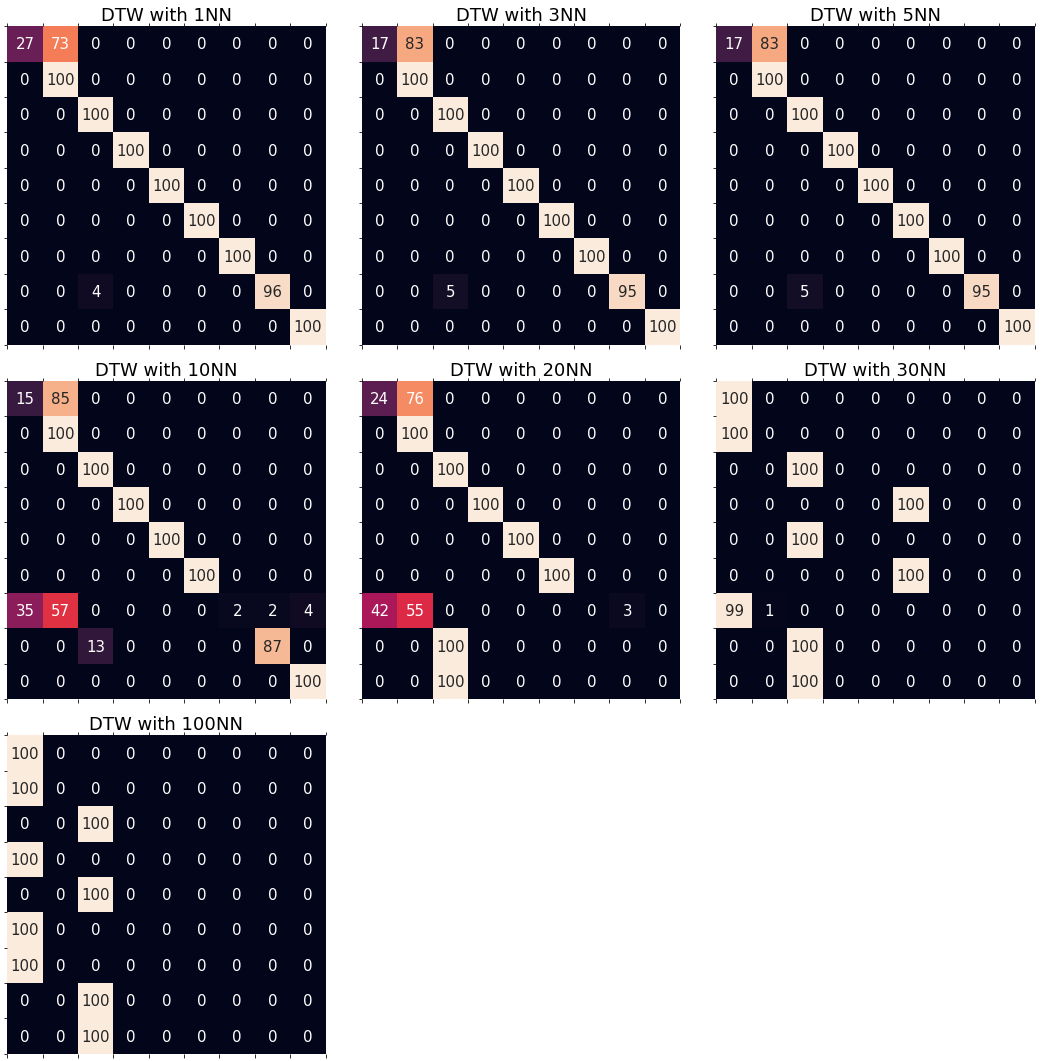

In [25]:
# how many plots based on # used k values
ncols = int(np.ceil(np.sqrt(len(k_lst))))
nrows = int(np.ceil(len(k_lst)/ncols))

y_true = test_df["true_label"]
plt.rcParams["figure.figsize"] = (5*ncols, 5*nrows)
plt.rcParams['font.size'] = min(5*nrows, 28)
fig, axes = plt.subplots(ncols = ncols, nrows = nrows)

for i,k in enumerate(k_lst):
    max_i = i
    ax = axes.flat[i]
    y_pred = predictions_dfs[f"{k}NN"]["pred"]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar = False)
    ax.matshow(cm)
    ax.set_title(f"DTW with {k}NN")

# hide unused axes
for i in range(max_i+1,len(axes.flat)):
    axes.flat[i].set_visible(False)

plt.tight_layout()
plt.show()

In [26]:
accuracies = dict()
for variant, df in predictions_dfs.items():
    if PARTIAL_MATCHES:
        variant = f"{variant}_partial"
    variant = variant + f"{window}"
    acc = utils.accuracy(y_true, df["pred"])
    accuracies[variant] = acc
    print(f"{variant} accuracy: {acc:.4f}")

1NN_partial accuracy: 0.9144
3NN_partial accuracy: 0.9022
5NN_partial accuracy: 0.9022
10NN_partial accuracy: 0.7822
20NN_partial accuracy: 0.5822
30NN_partial accuracy: 0.3333
100NN_partial accuracy: 0.2222


In [27]:
time_index = data["time_index"]
summary = {
    "data_filename": DATA_PICKLE_FILE,
    "classificator": CLS_NAME,
    "time_index": time_index,
    "split_id": SPLIT_ID,
    "predictions_dfs": predictions_dfs,
    "accuracies": accuracies,
    "total_time": total_time
}

for key, val in summary.items():
    print(f"{key}: {val}")

data_filename: data_HMM/HMM_data_ntrain25_min128_max128_unbal_1662222322.pkl
classificator: DTW
time_index: 1662222322
split_id: 0
predictions_dfs: {'1NN':       sample_id  true_label  sample_len  pred
68           68           0         128     1
69           69           0         128     0
70           70           0         128     1
71           71           0         128     1
72           72           0         128     1
...         ...         ...         ...   ...
1105       1105           8         128     8
1106       1106           8         128     8
1107       1107           8         128     8
1108       1108           8         128     8
1109       1109           8         128     8

[900 rows x 4 columns], '3NN':       sample_id  true_label  sample_len  pred
68           68           0         128     1
69           69           0         128     1
70           70           0         128     1
71           71           0         128     1
72           72           0   

In [28]:
gen_type = data["generating_model"]
split_id_str = str(SPLIT_ID)
if len(split_id_str) == 1:
    split_id_str = "0" + split_id_str

output_path = f"{RESULTS_DIR}/{FILENAME_INFIX}_{gen_type}_{time_index}_{split_id_str}.pkl"
if os.path.exists(output_path):
    inp = input(f"Classification results {output_path} already exists. Do you want to overwrite it? (y = yes)")
    if inp in ["y", "Y"]:
        with open(output_path, 'wb') as f:
                pickle.dump(summary, f)
                print(f"Updated classification results saved to {output_path}.")
    else:
        print("Canceled.")
else:
    with open(output_path, 'wb') as f:
        pickle.dump(summary, f)
        print(f"Classification results saved to {output_path}.")

Classification results saved to results_HMM/dtw_part_results_for_HMM_1662222322_00.pkl.
